In [8]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('', os.pardir)))
analysis_dir = os.path.abspath(os.path.join('', os.pardir))
sys.path.insert(0, os.path.abspath(os.path.join(analysis_dir, os.pardir)))
from utils.misc import read_json_file
from src.ml.helper.utils import parse_traces_config

analysis_dir = os.path.abspath(os.path.join('', os.pardir))
root_dir = os.path.abspath(os.path.join(analysis_dir, os.pardir))
root_dir

'/home/lorenzo/Desktop/mimic-2'

In [9]:
# Get config

# Select policy
policy = "adaptive_greedy_threshold"

log_dir_path = os.path.join(root_dir, 'log')
mab_dir_path = os.path.join(log_dir_path, 'mab', 'config')
config_file_name = policy + '.json'
file_path = os.path.join(mab_dir_path, config_file_name)
config = read_json_file(file_path)

# Get model timestamp
model_name = config["models"][0]['name']
model_ts = '.'.join(model_name.split('.')[1:])
model_ts

'2023.03.22.14.39.27'

In [10]:
# Read trace names and paths from YAML file
trace_data = parse_traces_config()
traces = [t for t in trace_data['traces'].keys()]
traces

['att.lte.driving',
 'att.lte.driving.2016',
 'tm.lte.driving',
 'tm.lte.short',
 'tm.umts.driving',
 'vz.evdo.driving',
 'vz.lte.driving',
 'vz.lte.short',
 'bus',
 'timessquare',
 'wired']

In [11]:
import re
from datetime import datetime

# Get iperf config
def get_config(tag):
    iperf_test_dir_path = os.path.join(log_dir_path, 'iperf')
    ts_list = []
    latest_timestamp = None

    for config_file in os.listdir(iperf_test_dir_path):
        if config_file.startswith(tag):
            full_path = os.path.join(iperf_test_dir_path, config_file)
            # print(config_file)
            pattern = r"\d{4}\.\d{2}\.\d{2}\.\d{2}\.\d{2}\.\d{2}"
            match = re.search(pattern, config_file)
            if not match:
                continue
            timestamp_str = match.group(0)
            timestamp = datetime.strptime(timestamp_str, "%Y.%m.%d.%H.%M.%S")
            ts_list.append(timestamp)
            # check if this timestamp is more recent
            if latest_timestamp is None or timestamp > latest_timestamp:
                latest_timestamp = timestamp
                mimic_config_file = full_path
    return mimic_config_file

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def cdf(x):
    N = len(x)

    # sort the data in ascending order
    x = np.sort(x)
    
    # get the cdf values of y
    y = np.arange(N) / float(N)

    return (x, y)


def get_metrics(config):
    rtts = []
    cwnds = []
    thruputs = [] 
    for intervals in config['intervals']:
        thruputs.append(intervals['streams'][0]['bits_per_second']*10**(-6))
        cwnds.append(intervals['streams'][0]['snd_cwnd'])
        rtts.append(intervals['streams'][0]['rtt'])
    return thruputs, rtts, cwnds

In [13]:
# Get metrics from config files

protocols = ['mimic', 'cubic', 'bbr', 'hybla']
thruputs, rtts, cwnds = {}, {}, {}
metrics = []
for trace in traces:
    for p in protocols:
        if p=='mimic':
            config = read_json_file(get_config(f"{trace}.{policy}"))
        else:
            # Get native prot config
            config = read_json_file(get_config(f"{p}.{trace}"))

        thruputs[p], rtts[p], cwnds[p] = get_metrics(config)

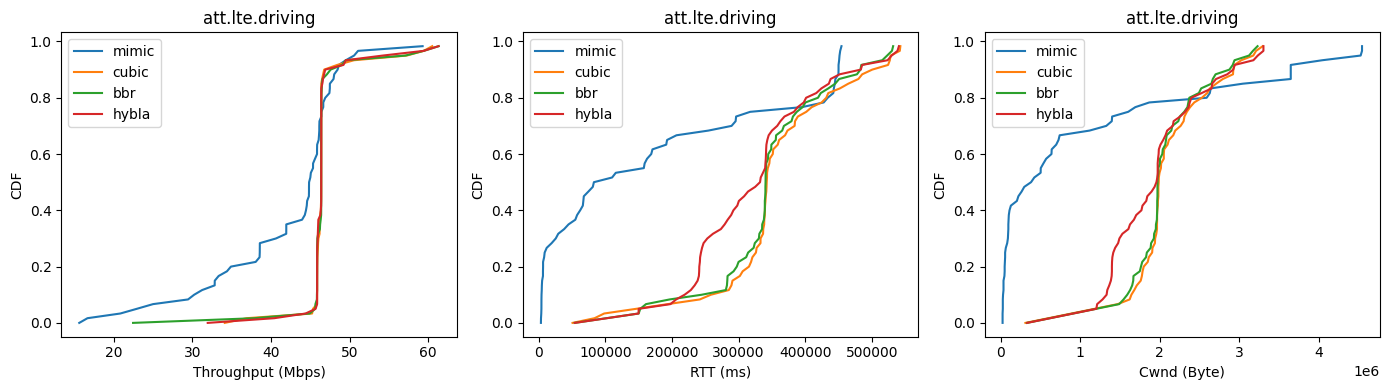

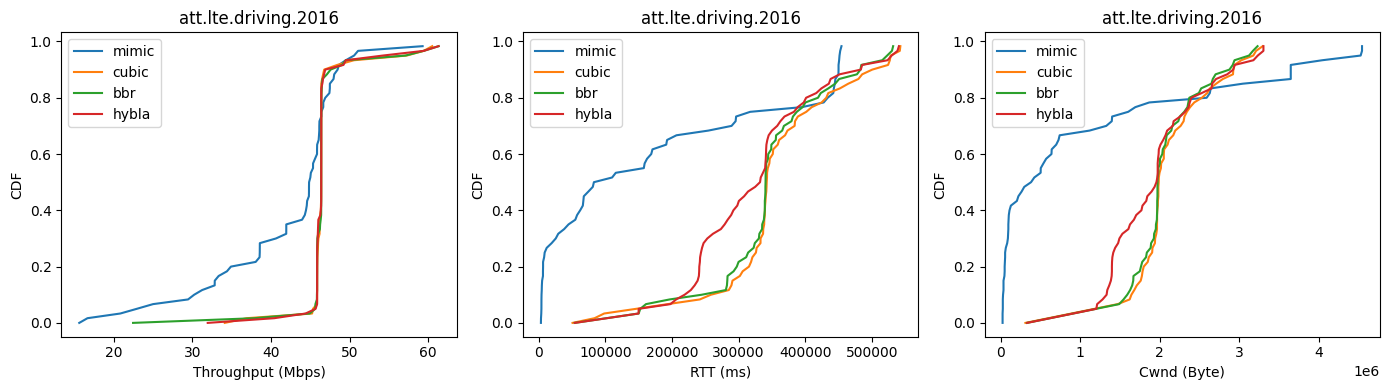

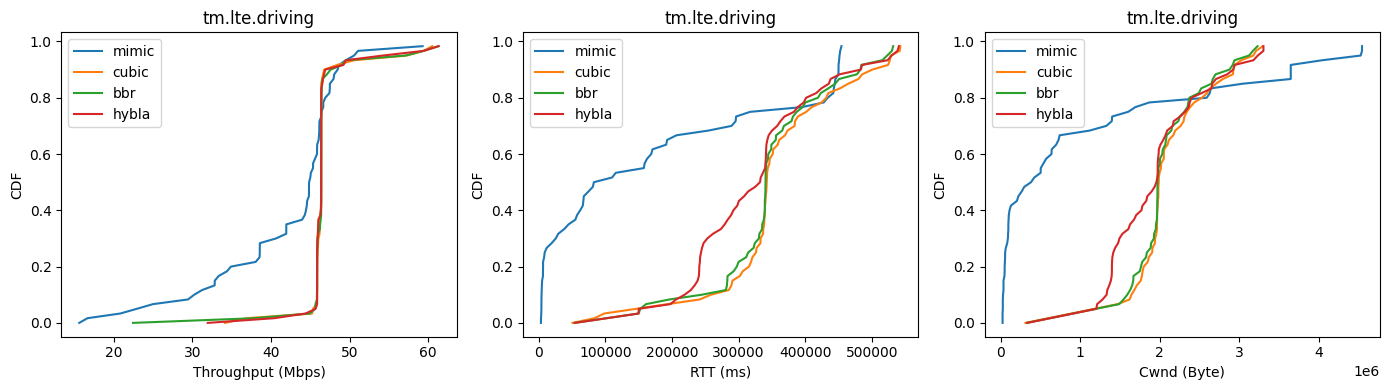

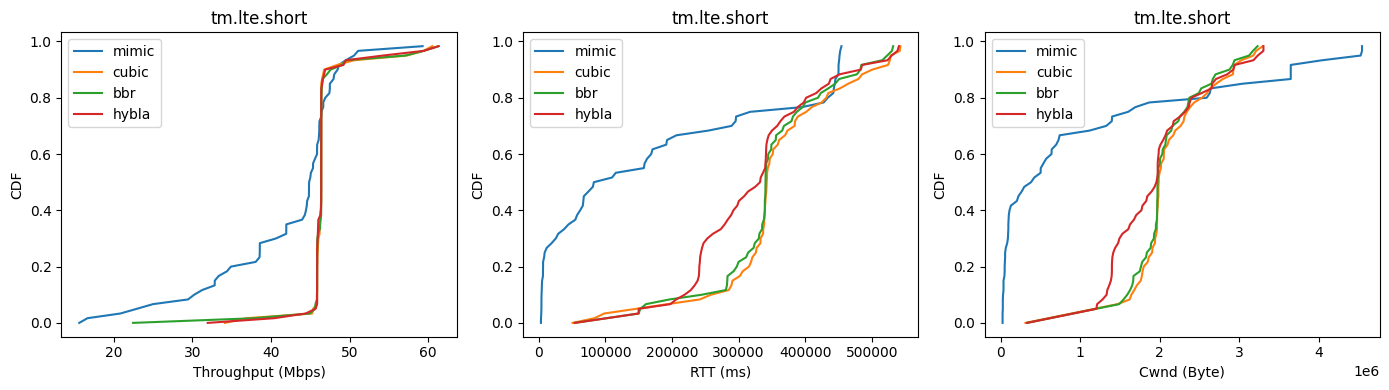

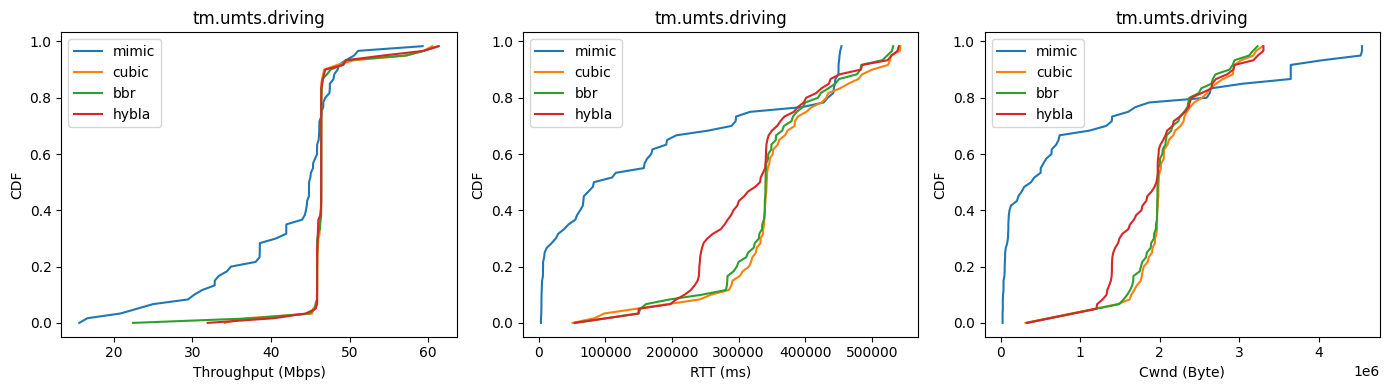

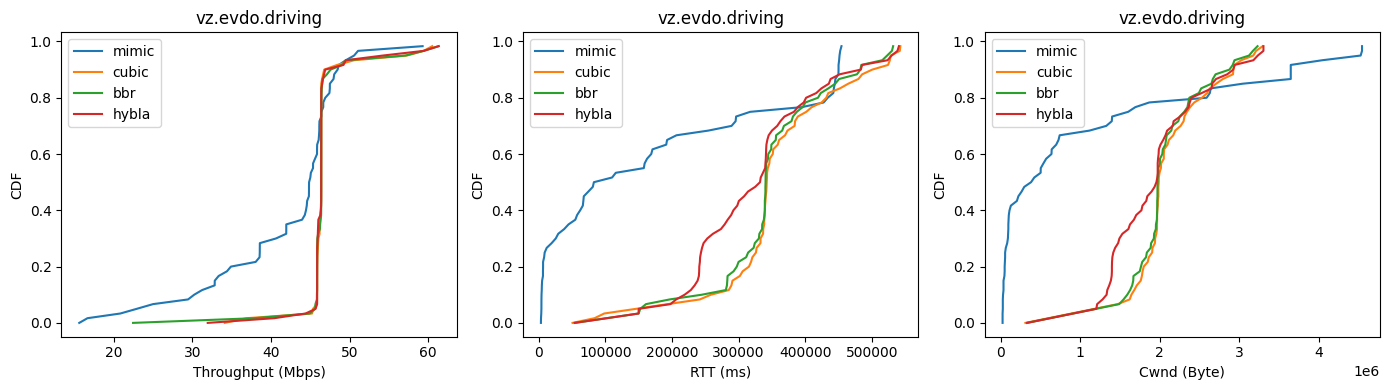

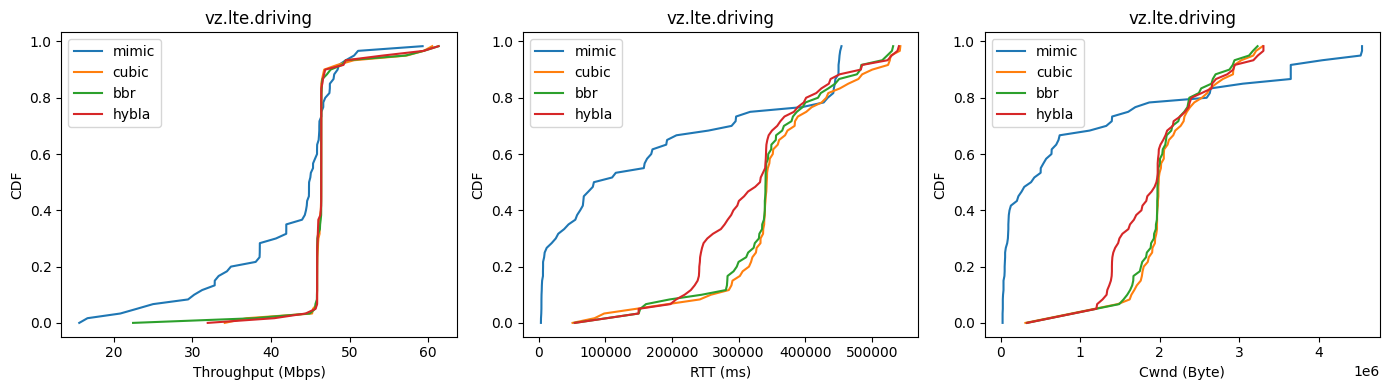

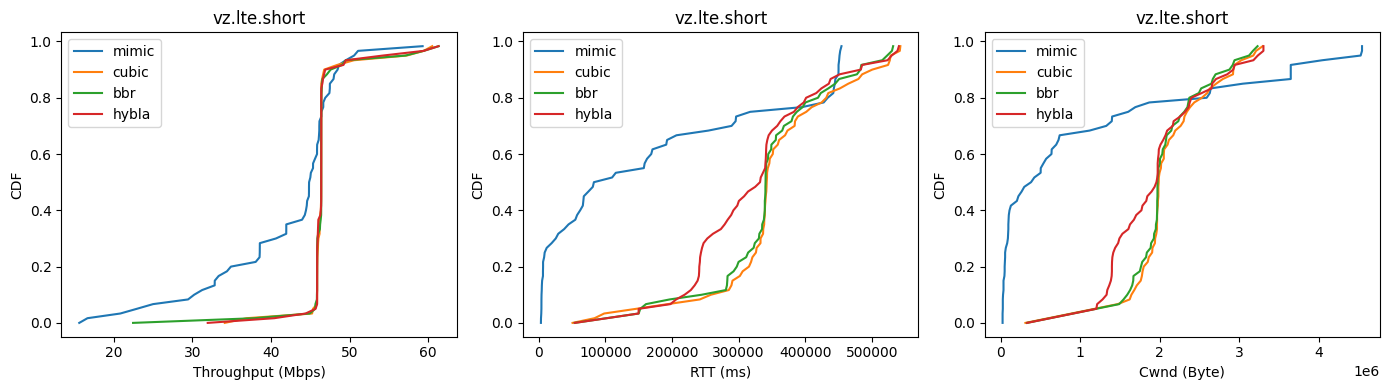

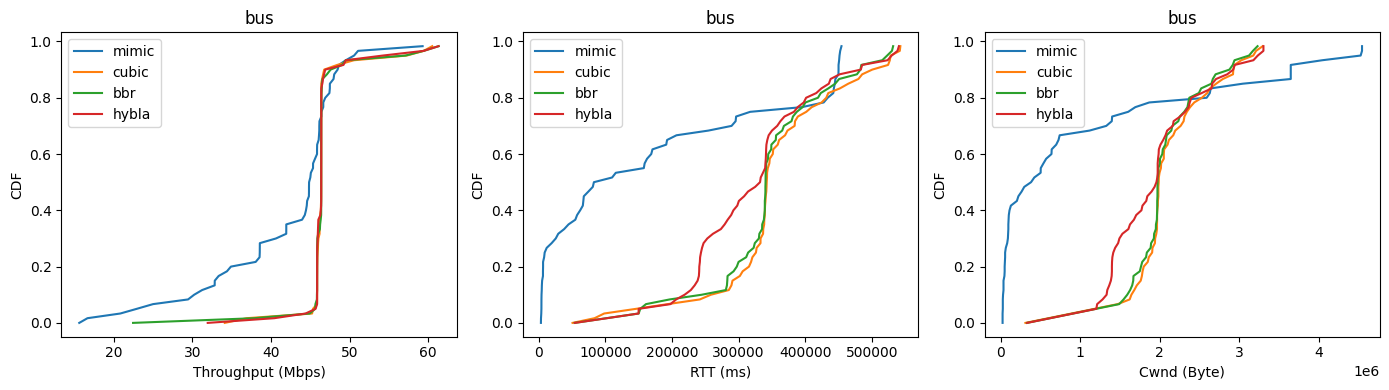

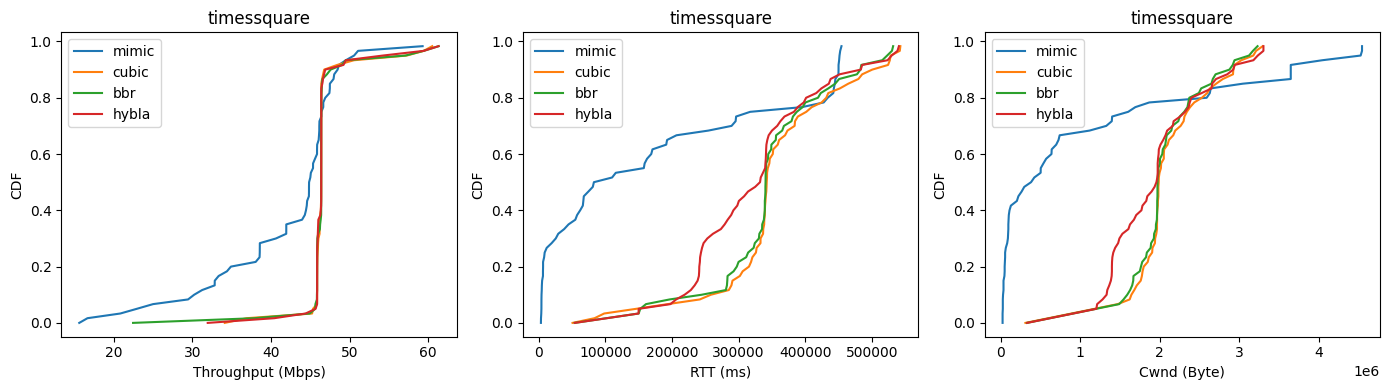

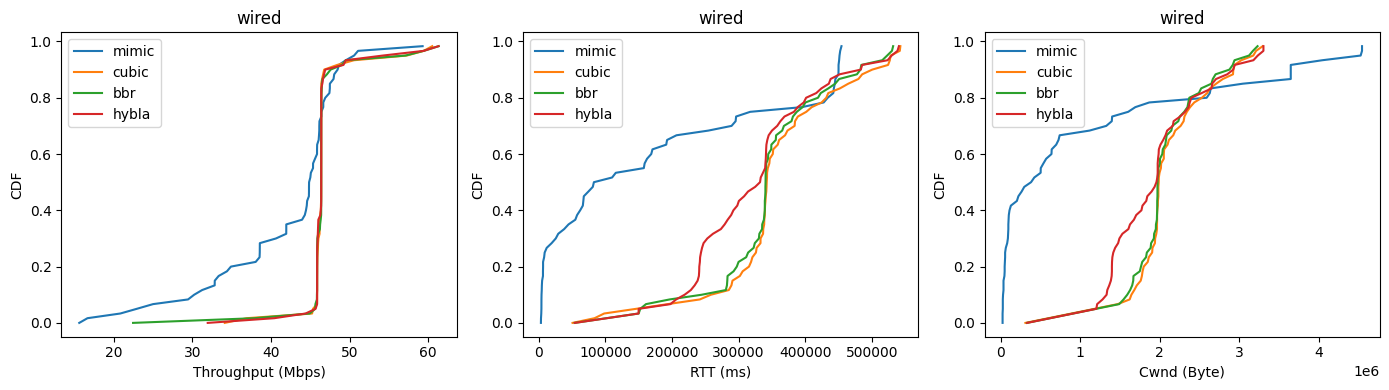

In [14]:
for trace in traces:
    plt.figure(figsize=(14,4))
    for p in protocols:
        (t_x, t_y) = cdf(thruputs[p])
        (r_x, r_y) = cdf(rtts[p])
        (c_x, c_y) = cdf(cwnds[p])

        plt.subplot(1, 3, 1)
        plt.plot(t_x, t_y, label=p)
        plt.xlabel('Throughput (Mbps)')
        plt.ylabel('CDF')
        plt.title(trace)
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(r_x, r_y, label=p)
        plt.xlabel('RTT (ms)')
        plt.ylabel('CDF')
        plt.title(trace)
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(c_x, c_y, label=p)
        plt.xlabel('Cwnd (Byte)')
        plt.ylabel('CDF')
        plt.title(trace)
        plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()